# Predicting with LSTMs -- Second round
i.e., full dataset, transformed to PCA

## Data preparation

In [1]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 67
numpy.random.seed(seed)

data = pandas.read_csv("../data/processed/train.csv")
notnull_data = data[data.notnull().all(axis=1)]
train = notnull_data.values
data2 = pandas.read_csv("../data/processed/test.csv")
notnull_data2 = data2[data2.notnull().all(axis=1)]
test = notnull_data2.values

Using Theano backend.


In [2]:
X_train = train[:,3:7558].astype(float)
Y_trainA = train[:,7558] #Activity
Y_trainS = train[:,7559] #Social
X_test = test[:,3:7558].astype(float)
Y_testA = test[:,7558]
Y_testS = test[:,7559]

# One hot encoding of the response variable (using dummy variables)
from keras.utils.np_utils import to_categorical

# encode class values as integers
encoderA = LabelEncoder()
encoderA.fit(Y_trainA)
encoded_Y_trainA = encoderA.transform(Y_trainA)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_trainA = to_categorical(encoded_Y_trainA)
encoderA.fit(Y_testA)
encoded_Y_testA = encoderA.transform(Y_testA)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_testA = to_categorical(encoded_Y_testA)

# encode class values as integers
encoderS = LabelEncoder()
encoderS.fit(Y_trainS)
encoded_Y_trainS = encoderS.transform(Y_trainS)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_trainS = to_categorical(encoded_Y_trainS)
encoderS.fit(Y_testS)
encoded_Y_testS = encoderS.transform(Y_testS)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_testS = to_categorical(encoded_Y_testS)

# We standardize on the basis of the training data
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# Number of components to extract from the dataset
n_components = 100

from sklearn import decomposition
print 'Reducing dataset with PCA',n_components
pca = decomposition.PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_st)
X_test_pca = pca.transform(X_test_st)

#print 'Variance explained:'
#print pca.explained_variance_ratio_
print 'Total variance explained by %d components:',n_components
print sum(pca.explained_variance_ratio_)

trainX = numpy.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
testX = numpy.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))


Reducing dataset with PCA 100
Total variance explained by %d components: 100
0.630815671837


In [3]:
from keras.layers import Dropout
from keras.layers import LSTM
from keras.constraints import maxnorm
from keras.optimizers import SGD

# This is our winning architecture so far
def create_LSTM3_PCA(n_outputs, batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(200, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_LSTM2_PCA(n_outputs, batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(300, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_LSTM1_PCA(n_outputs, batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(400, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, cohen_kappa_score

def printValStats(model, testX, dummy_y_test, batch=1):
    # Other performance/accuracy metrics
    Y_pred = model.predict(testX, batch_size=batch)
    model.reset_states()
    print 'Performance of model on test set ----------------------------'
    # Accuracy
    print('Accuracy:')
    print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))
    # Kappa
    print('Kappa:')
    kappa = cohen_kappa_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
    print(kappa)
    # Confusion matrix
    cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
    numpy.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(cm)
    # AUC
    roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
    print('AUC score:')
    print(roc)
    return kappa, roc

def plot_training(accs, val_accs, losss, val_losss, kappas, aucs):
    # summarize history for accuracy
    plt.plot(accs)
    plt.plot(val_accs)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(losss)
    plt.plot(val_losss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()
    # summarize kappa and auc
    plt.plot(kappas)
    plt.plot(aucs)
    plt.title('Other performance')
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['Kappa','AUC'], loc='upper left')
    plt.show()
    
    
import operator

def get_max_values(list):
    index, value = max(enumerate(list), key=operator.itemgetter(1))
    return index, value

print 'Ready for training!'

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Ready for training!


## Predicting Social

### 3-layer LSTM

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
lstm_1 (LSTM)                      (1, 1, 200)         240800      lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)                (1, 1, 200)         0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                      (1, 1, 100)         120400      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)                (1, 1, 100)         0           lstm_2[0][0]                     
___________________________________________________________________________________________

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 74s - loss: 0.9179 - acc: 0.6440 - val_loss: 1.2108 - val_acc: 0.6159
Performance of model on test set ----------------------------
Accuracy:
0.614942528736
Kappa:
0.0206493254958
Confusion matrix:
[[642   0   5   0]
 [218   0   0   1]
 [ 23   0   0   1]
 [138   0  16   0]]
AUC score:
0.565920196673
('Epoch', 2, '/', 100)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 106s - loss: 0.7645 - acc: 0.7330 - val_loss: 1.3155 - val_acc: 0.5939
Performance of model on test set ----------------------------
Accuracy:
0.592911877395
Kappa:
0.14246784496
Confusion matrix:
[[612   0  28   7]
 [134   0  75  10]
 [ 18   0   6   0]
 [111   0  42   1]]
AUC score:
0.653253856512
('Epoch', 3, '/', 100)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 115s - loss: 0.6713 - acc: 0.7683 - val_loss

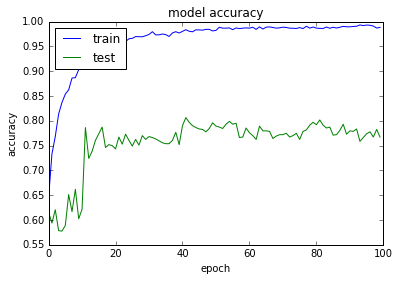

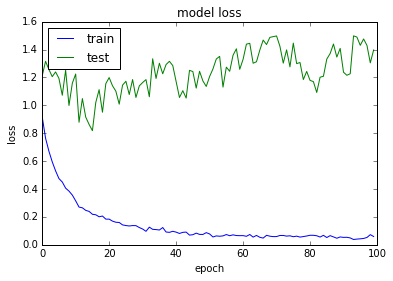

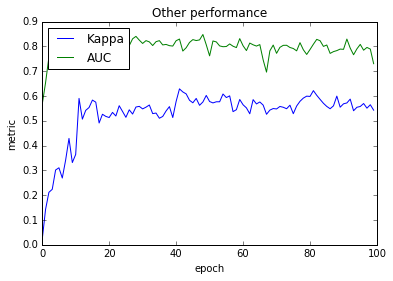

In [ ]:
# Create the model and parameters for training
numpy.random.seed(seed)

batch = 1
epochs = 100

modelS3 = create_LSTM3_PCA(dummy_y_trainS.shape[1], batch_size = batch, trainShape1=n_components)
print modelS3.summary()

# To save the best model
# serialize model to JSON
modelS3_json = modelS3.to_json()
with open("social.model--3lstmbis.json", "w") as json_file:
    json_file.write(modelS3_json)
filepathS3="social.weights--3lstmbis.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpointS3 = ModelCheckpoint(filepathS3, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_listS3 = [checkpointS3]

# Fit the model
accs =[]
val_accs =[]
losss =[]
val_losss =[]
kappas = []
aucs = []

# Manually create epochs and reset between sessions
for i in range(epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', epochs)
    history = modelS3.fit(trainX, dummy_y_trainS, validation_data=(testX, dummy_y_testS), 
                        nb_epoch=1, batch_size=batch, shuffle=False, 
                        verbose=1, callbacks=callbacks_listS3)
    modelS3.reset_states()
    kappa, auc = printValStats(modelS3, testX, dummy_y_testS, batch=batch)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])
    kappas.append(kappa)
    aucs.append(auc)
    
print 'Best validation accuracy: ', get_max_values(val_accs)
plot_training(accs, val_accs, losss, val_losss, kappas, aucs)

In [6]:
print 'Best validation accuracy: ', get_max_values(val_accs)
print 'Best validation Kappa: ', get_max_values(kappas)
print 'Best validation AUC: ', get_max_values(aucs)

Best validation accuracy:  (41, 0.80651340996168586)
Best validation Kappa:  (41, 0.62877492168359805)
Best validation AUC:  (48, 0.84802145297650755)


### 2-layer (wider) LSTM

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
lstm_4 (LSTM)                      (1, 1, 300)         481200      lstm_input_2[0][0]               
____________________________________________________________________________________________________
dropout_6 (Dropout)                (1, 1, 300)         0           lstm_4[0][0]                     
____________________________________________________________________________________________________
lstm_5 (LSTM)                      (1, 50)             70200       dropout_6[0][0]                  
____________________________________________________________________________________________________
dropout_7 (Dropout)                (1, 50)             0           lstm_5[0][0]                     
___________________________________________________________________________________________

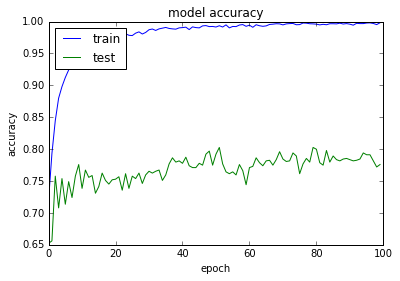

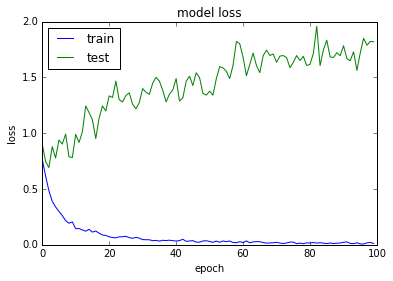

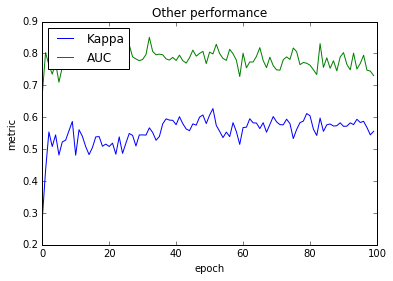

In [7]:
# Create the model and parameters for training
numpy.random.seed(seed)

batch = 1
epochs = 100

modelS2 = create_LSTM2_PCA(dummy_y_trainS.shape[1], batch_size = batch, trainShape1=n_components)
print modelS2.summary()

# To save the best model
# serialize model to JSON
modelS2_json = modelS2.to_json()
with open("social.model--2lstmbis.json", "w") as json_file:
    json_file.write(modelS2_json)
filepathS2="social.weights--2lstmbis.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpointS2 = ModelCheckpoint(filepathS2, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_listS2 = [checkpointS2]

# Fit the model
accs =[]
val_accs =[]
losss =[]
val_losss =[]
kappas = []
aucs = []

# Manually create epochs and reset between sessions
for i in range(epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', epochs)
    history = modelS2.fit(trainX, dummy_y_trainS, validation_data=(testX, dummy_y_testS), 
                        nb_epoch=1, batch_size=batch, shuffle=False, 
                        verbose=1, callbacks=callbacks_listS2)
    modelS2.reset_states()
    kappa, auc = printValStats(modelS2, testX, dummy_y_testS, batch=batch)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])
    kappas.append(kappa)
    aucs.append(auc)
    
print 'Best validation accuracy: ', get_max_values(val_accs)
print 'Best validation Kappa: ', get_max_values(kappas)
print 'Best validation AUC: ', get_max_values(aucs)
plot_training(accs, val_accs, losss, val_losss, kappas, aucs)

### 1-layer (wider) LSTM

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
lstm_6 (LSTM)                      (1, 400)            801600      lstm_input_3[0][0]               
____________________________________________________________________________________________________
dropout_10 (Dropout)               (1, 400)            0           lstm_6[0][0]                     
____________________________________________________________________________________________________
dense_7 (Dense)                    (1, 50)             20050       dropout_10[0][0]                 
____________________________________________________________________________________________________
dropout_11 (Dropout)               (1, 50)             0           dense_7[0][0]                    
___________________________________________________________________________________________

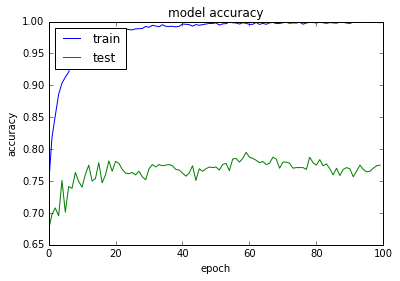

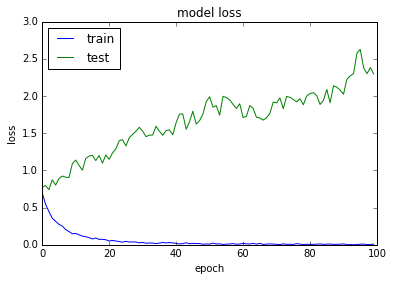

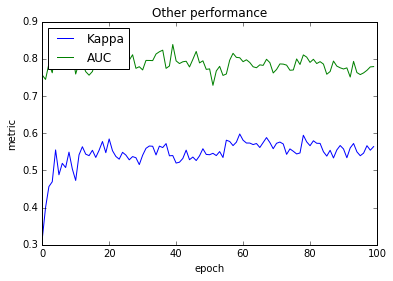

In [8]:
# Create the model and parameters for training
numpy.random.seed(seed)

batch = 1
epochs = 100

modelS1 = create_LSTM1_PCA(dummy_y_trainS.shape[1], batch_size = batch, trainShape1=n_components)
print modelS1.summary()

# To save the best model
# serialize model to JSON
modelS1_json = modelS1.to_json()
with open("social.model--1lstmbis.json", "w") as json_file:
    json_file.write(modelS1_json)
filepathS1="social.weights--1lstmbis.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpointS1 = ModelCheckpoint(filepathS1, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_listS1 = [checkpointS1]

# Fit the model
accs =[]
val_accs =[]
losss =[]
val_losss =[]
kappas = []
aucs = []

# Manually create epochs and reset between sessions
for i in range(epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', epochs)
    history = modelS1.fit(trainX, dummy_y_trainS, validation_data=(testX, dummy_y_testS), 
                        nb_epoch=1, batch_size=batch, shuffle=False, 
                        verbose=1, callbacks=callbacks_listS1)
    modelS1.reset_states()
    kappa, auc = printValStats(modelS1, testX, dummy_y_testS, batch=batch)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])
    kappas.append(kappa)
    aucs.append(auc)
    
print 'Best validation accuracy: ', get_max_values(val_accs)
print 'Best validation Kappa: ', get_max_values(kappas)
print 'Best validation AUC: ', get_max_values(aucs)
plot_training(accs, val_accs, losss, val_losss, kappas, aucs)

So, apparently, the 3-layer LSTM gets slightly better results than shallower RNNs